In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
# Path to pretrained model
MODEL_PATH = "/content/drive/My Drive/retina_segmentation_8_layer.hdf5"

# Path to your raw OCT images
OCT_DIR = "/content/drive/My Drive/RetinalDataset/images"

# Path to save segmented outputs
OUT_DIR = "/content/drive/My Drive/RetinalDataset/segmented"
os.makedirs(OUT_DIR, exist_ok=True)


In [ ]:
import tensorflow as tf

# Define a fixed Conv2DTranspose that accepts 'groups' but ignores it (since groups=1 is default)
class FixedConv2DTranspose(tf.keras.layers.Conv2DTranspose):
    def __init__(self, *args, groups=1, **kwargs):
        if groups != 1:
            raise ValueError("Only groups=1 is supported.")
        # Call parent without 'groups'
        super().__init__(*args, **kwargs)

# Load model with custom object
model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={'Conv2DTranspose': FixedConv2DTranspose}
)

print("✅ Model loaded successfully!")

/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


✅ Model loaded successfully!


In [ ]:
import cv2, numpy as np, os
from keras.utils import normalize
import matplotlib.pyplot as plt

SIZE = 640  # model expects 640×640 inputs

for img_file in os.listdir(OCT_DIR):
    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(OCT_DIR, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (SIZE, SIZE))
        img_norm = normalize(np.expand_dims(img, axis=(0,3)), axis=1)

        pred = model.predict(img_norm)
        pred_mask = np.argmax(pred, axis=3)[0,:,:]

        # Save prediction
        out_path = os.path.join(OUT_DIR, img_file)
        plt.imsave(out_path, pred_mask, cmap='jet')

        print("Segmented:", img_file)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Segmented: NORMAL8.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Segmented: NORMAL10.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Segmented: NORMAL14.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Segmented: NORMAL19.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Segmented: NORMAL18.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Segmented: NORMAL5.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Segmented: NORMAL20.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Segmented: NORMAL9.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Segmented: NORMAL6.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Segmented: NORMAL2.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Segmented: NORMAL11.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Segmented: NORMAL17.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Segmented: NORMAL7.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Segmented: NORMAL21.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Segmented: NORMAL3.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Segmented: NORMAL22.jpeg
1/1 ━━━━━━━━━━━━━━━

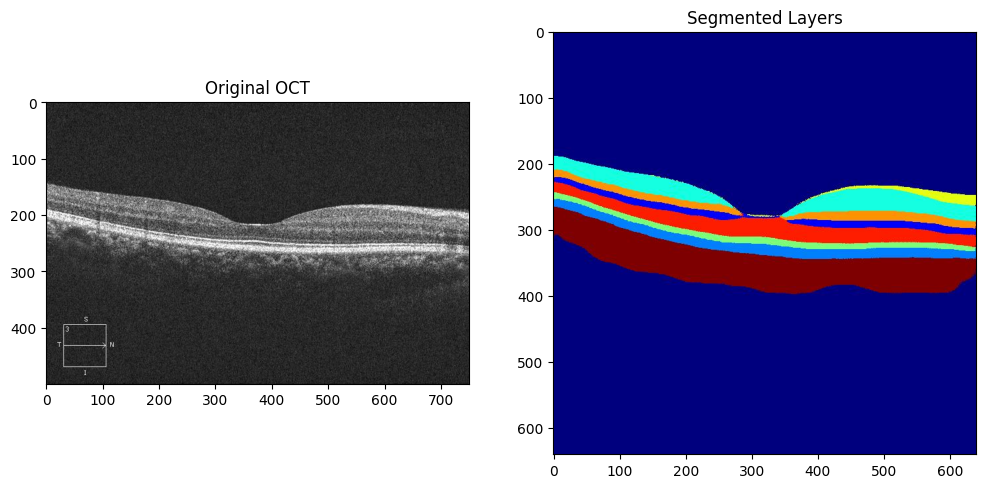

In [ ]:
test_img = cv2.imread(os.path.join(OCT_DIR, os.listdir(OCT_DIR)[0]), 0)
pred_img = plt.imread(os.path.join(OUT_DIR, os.listdir(OUT_DIR)[0]))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(test_img, cmap='gray')
plt.title('Original OCT')

plt.subplot(1,2,2)
plt.imshow(pred_img, cmap='jet')
plt.title('Segmented Layers')
plt.show()


In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Set up paths - make sure these match your setup
SEGMENTED_DIR = "/content/drive/My Drive/RetinalDataset/segmented"
OUT_DIR = "/content/drive/My Drive/RetinalDataset/etdrs_features"
os.makedirs(OUT_DIR, exist_ok=True)

# Set correct microns per pixel for your OCT scanner
UM_PER_PIXEL = 3.9  # Update this based on your scanner specifications

# Layer mapping based on your model (verify these match your segmentation)
LAYER_MAP = {
    1: 'RNFL',      # Nerve Fiber Layer
    2: 'GCL+IPL'    # Ganglion Cell Layer + Inner Plexiform Layer
}

def etdrs_sector_masks(height, width, center=None):
    """Generate 9 ETDRS sector masks (center + 4 inner + 4 outer)"""
    # Define radii for ETDRS sectors (in pixels)
    # Using standard ETDRS diameters: 1mm, 3mm, 6mm
    # Convert to pixels based on scanner's resolution
    # For simplicity, we'll assume the image width corresponds to 6mm (standard OCT scan width)
    mm_per_pixel = 6.0 / width  # 6mm across the full image width

    # Radii in pixels
    r0 = (0.5 / mm_per_pixel)  # 0.5mm = central 1mm diameter
    r1 = (1.5 / mm_per_pixel)  # 1.5mm = inner 3mm diameter
    r2 = (3.0 / mm_per_pixel)  # 3.0mm = outer 6mm diameter

    # If center not provided, use image center
    if center is None:
        cx = width // 2
        cy = height // 2
    else:
        cx, cy = center

    # Create coordinate grid
    Y, X = np.ogrid[:height, :width]

    # Calculate distance from center
    dist = np.sqrt((X - cx)**2 + (Y - cy)**2)

    # Define rings: 0 = center (r <= r0), 1 = inner (r0 < r <= r1), 2 = outer (r1 < r <= r2)
    ring = np.zeros((height, width), dtype=int)
    ring[dist > r0] = 1
    ring[dist > r1] = 2

    # Calculate angles for quadrants (0-360 degrees)
    ang = (np.degrees(np.arctan2(cy - Y, X - cx)) + 360) % 360

    # Define quadrants
    quadrant = np.zeros((height, width), dtype=int)
    quadrant[(ang >= 0) & (ang < 90)] = 0   # Temporal
    quadrant[(ang >= 90) & (ang < 180)] = 1  # Superior
    quadrant[(ang >= 180) & (ang < 270)] = 2 # Nasal
    quadrant[(ang >= 270) & (ang < 360)] = 3 # Inferior

    # Create the 9 sector masks
    masks = []
    # Center sector (0)
    masks.append(ring == 0)

    # Inner ring quadrants (1-4)
    for q in range(4):
        masks.append((ring == 1) & (quadrant == q))

    # Outer ring quadrants (5-8)
    for q in range(4):
        masks.append((ring == 2) & (quadrant == q))

    return masks, (cx, cy, r0, r1, r2)

def calculate_thickness(mask, layer_id):
    """Calculate thickness map for a specific layer"""
    # Create binary mask for the layer
    layer_mask = (mask == layer_id)

    # Calculate thickness per column (vertical dimension)
    thickness = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float32)

    for col in range(mask.shape[1]):
        # Find all pixels in this column that belong to the layer
        layer_pixels = np.where(layer_mask[:, col])[0]

        if len(layer_pixels) > 0:
            # Thickness is the distance between the top and bottom layer pixels
            thickness[:, col] = layer_pixels[-1] - layer_pixels[0] + 1

    # Convert to microns
    thickness *= UM_PER_PIXEL

    return thickness

def extract_etdrs_features(mask, center=None):
    """Extract ETDRS features from segmentation mask"""
    height, width = mask.shape
    sector_masks, center_info = etdrs_sector_masks(height, width, center)
    cx, cy = center_info[:2]

    features = {}

    # Extract features for RNFL (layer 1)
    if 1 in LAYER_MAP:
        rnfl_thickness = calculate_thickness(mask, 1)
        for i in range(9):
            sector_mask = sector_masks[i]
            sector_thickness = rnfl_thickness[sector_mask]
            if len(sector_thickness) > 0:
                features[f"RNFL_mean_s{i+1}"] = np.mean(sector_thickness)
                features[f"RNFL_std_s{i+1}"] = np.std(sector_thickness)
            else:
                features[f"RNFL_mean_s{i+1}"] = 0
                features[f"RNFL_std_s{i+1}"] = 0

    # Extract features for GCL (layer 2)
    if 2 in LAYER_MAP:
        gcl_thickness = calculate_thickness(mask, 2)
        for i in range(9):
            sector_mask = sector_masks[i]
            sector_thickness = gcl_thickness[sector_mask]
            if len(sector_thickness) > 0:
                features[f"GCL_mean_s{i+1}"] = np.mean(sector_thickness)
                features[f"GCL_std_s{i+1}"] = np.std(sector_thickness)
            else:
                features[f"GCL_mean_s{i+1}"] = 0
                features[f"GCL_std_s{i+1}"] = 0

    # Calculate global features
    features["RNFL_mean_total"] = np.mean([features[f"RNFL_mean_s{i+1}"] for i in range(9)])
    features["GCL_mean_total"] = np.mean([features[f"GCL_mean_s{i+1}"] for i in range(9)])

    # Calculate asymmetry features (left vs right)
    # Assuming sectors 0,1,2 are right and 6,7,8 are left (adjust based on your quadrant definition)
    features["RNFL_lr_asym"] = (features["RNFL_mean_s1"] + features["RNFL_mean_s2"] + features["RNFL_mean_s3"]) - \
                              (features["RNFL_mean_s7"] + features["RNFL_mean_s8"] + features["RNFL_mean_s9"])
    features["GCL_lr_asym"] = (features["GCL_mean_s1"] + features["GCL_mean_s2"] + features["GCL_mean_s3"]) - \
                              (features["GCL_mean_s7"] + features["GCL_mean_s8"] + features["GCL_mean_s9"])

    # Add center information
    features["center_x"] = cx
    features["center_y"] = cy

    return features

# Process all segmented images
results = []
for img_file in tqdm(os.listdir(SEGMENTED_DIR)):
    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(SEGMENTED_DIR, img_file)

        # Read the segmented mask (it's a grayscale image)
        mask = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # If mask is None, skip
        if mask is None:
            continue

        # Extract features
        features = extract_etdrs_features(mask)
        features["image"] = img_file

        # Add to results
        results.append(features)

        # Optional: visualize the ETDRS sectors on the mask
        if len(results) <= 5:  # Visualize first 5
            plt.figure(figsize=(15, 5))

            # Plot segmentation mask
            plt.subplot(1, 3, 1)
            plt.imshow(mask, cmap='tab10')
            plt.title("Segmentation Mask")

            # Plot thickness maps
            plt.subplot(1, 3, 2)
            rnfl_thickness = calculate_thickness(mask, 1)
            plt.imshow(rnfl_thickness, cmap='hot')
            plt.colorbar()
            plt.title("RNFL Thickness (μm)")

            # Plot ETDRS sectors
            plt.subplot(1, 3, 3)
            sector_mask = np.zeros_like(mask)
            _, (cx, cy, _, _, _) = etdrs_sector_masks(mask.shape[0], mask.shape[1])
            sector_mask[cy, cx] = 10  # Mark center

            for i, sector in enumerate(etdrs_sector_masks(mask.shape[0], mask.shape[1])[0]):
                sector_mask[sector] = i+1

            plt.imshow(sector_mask, cmap='tab10')
            plt.title("ETDRS Sectors")

            plt.tight_layout()
            plt.savefig(os.path.join(OUT_DIR, f"{img_file}_etdrs_vis.png"))
            plt.close()

# Save features to CSV
features_df = pd.DataFrame(results)
features_df.to_csv(os.path.join(OUT_DIR, "etdrs_features.csv"), index=False)
print("ETDRS features calculated and saved to", os.path.join(OUT_DIR, "etdrs_features.csv"))
print("First 5 rows of features:")
print(features_df.head())

100%|██████████| 206/206 [00:18<00:00, 11.28it/s]

ETDRS features calculated and saved to /content/drive/My Drive/RetinalDataset/etdrs_features/etdrs_features.csv
First 5 rows of features:
   RNFL_mean_s1  RNFL_std_s1  RNFL_mean_s2  RNFL_std_s2  RNFL_mean_s3  \
0      0.545433     2.699620      0.388056     2.017708      0.227986   
1      0.211895     0.884020      0.150025     0.750060      0.267731   
2      0.231951     0.922392      0.208332     0.876979      0.350714   
3      0.465210     1.264080      0.431732     1.223668      0.342416   
4      0.446898     1.242249      0.445053     1.511191      0.322762   

   RNFL_std_s3  RNFL_mean_s4  RNFL_std_s4  RNFL_mean_s5  RNFL_std_s5  ...  \
0     0.914968      0.229733     0.918249      0.386746     2.016694  ...   
1     0.986139      0.269041     0.988371      0.148933     0.747435  ...   
2     1.115699      0.352461     1.118199      0.207022     0.874372  ...   
3     1.405154      0.344381     1.409213      0.430422     1.222040  ...   
4     1.074521      0.324509     1.077

Synthetic dataset saved to: /content/drive/My Drive/RetinalDataset/synthetic_data/synthetic_training_data.csv
Generated 1000 samples (balanced)

Clinical Statistics:
Mean RNFL (Normal): 94.41 μm
Mean RNFL (AD): 70.57 μm
Mean GCL (Normal): 32.58 μm
Mean GCL (AD): 24.18 μm


/tmp/ipython-input-3430869716.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


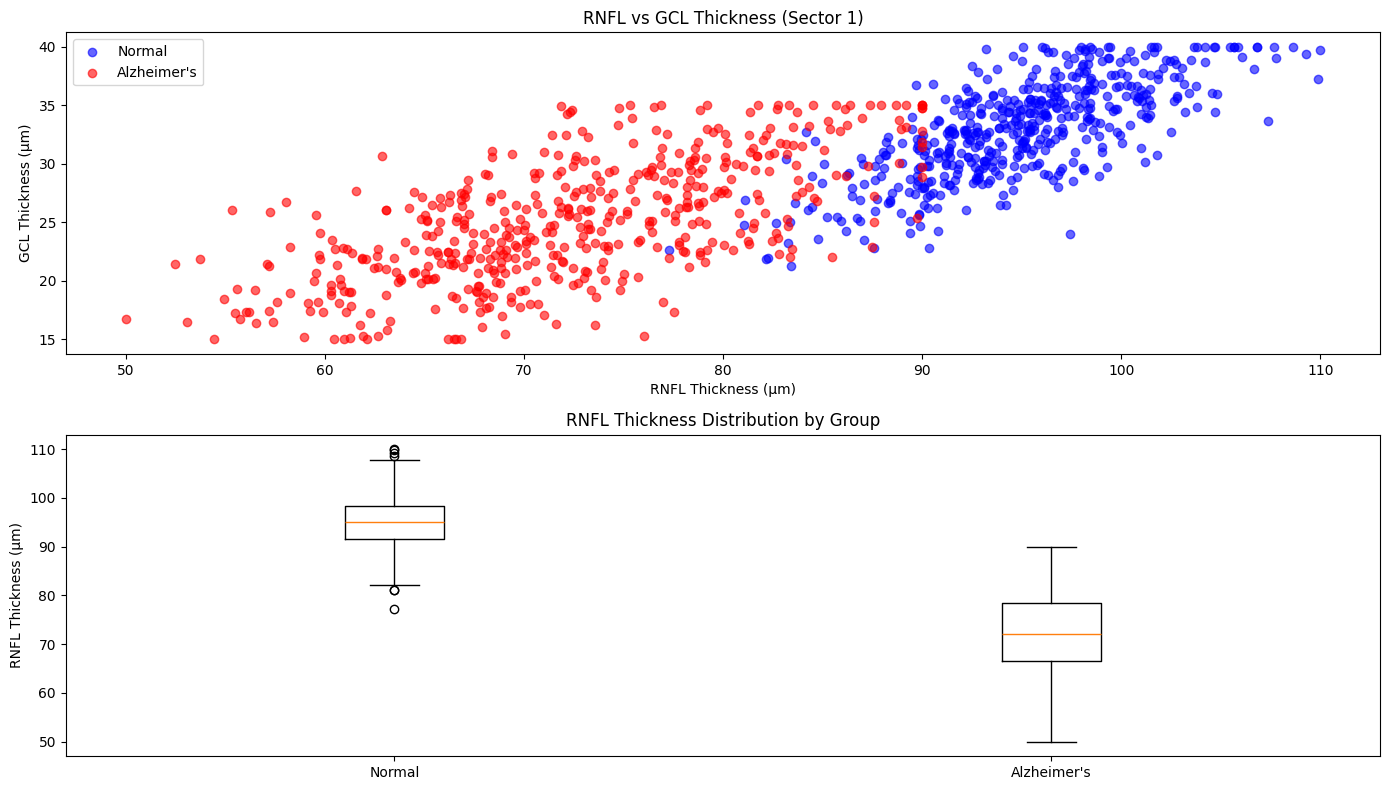

✅ Visualization saved to: /content/drive/My Drive/RetinalDataset/synthetic_data/synthetic_data_visualization.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

# Mount Google Drive if needed
# drive.mount('/content/drive')

# === Synthetic OCT Layer Thickness Generator (Enhanced) ===
def generate_synthetic_data(n_samples=1000, random_state=42):
    np.random.seed(random_state)
    data = []

    # Clinical parameters (μm)
    normal_rnfl_mean, normal_rnfl_std = 95, 5
    normal_gcl_mean, normal_gcl_std = 33, 4
    ad_rnfl_mean, ad_rnfl_std = 72, 8
    ad_gcl_mean, ad_gcl_std = 25, 5

    # Covariance between RNFL and GCL thickness (correlation ~0.8)
    corr_matrix = np.array([[1.0, 0.8],
                            [0.8, 1.0]])

    def generate_correlated_thickness(mean_rnfl, std_rnfl, mean_gcl, std_gcl, n_sectors=9):
        # Cholesky decomposition for correlation
        L = np.linalg.cholesky(corr_matrix)
        uncorrelated = np.random.randn(2, n_sectors)
        correlated = L @ uncorrelated
        rnfl = correlated[0] * std_rnfl + mean_rnfl
        gcl = correlated[1] * std_gcl + mean_gcl
        return rnfl, gcl

    # ---- Generate Normal Subjects (label = 0) ----
    for _ in range(n_samples // 2):
        rnfl, gcl = generate_correlated_thickness(normal_rnfl_mean, normal_rnfl_std,
                                                  normal_gcl_mean, normal_gcl_std)

        # Anatomical asymmetry: temporal sectors thinner
        rnfl[1] -= 2; rnfl[3] -= 3
        gcl[1] -= 1.5; gcl[3] -= 2.0

        # Random small anatomical noise
        rnfl += np.random.normal(0, 1.5, 9)
        gcl += np.random.normal(0, 1.5, 9)

        rnfl = np.clip(rnfl, 65, 110)
        gcl = np.clip(gcl, 20, 40)

        row = {f"RNFL_mean_s{i+1}": rnfl[i] for i in range(9)}
        row.update({f"GCL_mean_s{i+1}": gcl[i] for i in range(9)})
        row["label"] = 0
        row["AD_risk"] = max(0, min(1, (100 - np.mean(rnfl)) / 35))
        data.append(row)

    # ---- Generate AD Subjects (label = 1) ----
    for _ in range(n_samples // 2):
        rnfl, gcl = generate_correlated_thickness(ad_rnfl_mean, ad_rnfl_std,
                                                  ad_gcl_mean, ad_gcl_std)

        # Stronger thinning in temporal sectors
        rnfl[1] -= 5; rnfl[3] -= 7
        gcl[1] -= 3; gcl[3] -= 4

        rnfl += np.random.normal(0, 2.5, 9)
        gcl += np.random.normal(0, 2.5, 9)

        rnfl = np.clip(rnfl, 50, 90)
        gcl = np.clip(gcl, 15, 35)

        row = {f"RNFL_mean_s{i+1}": rnfl[i] for i in range(9)}
        row.update({f"GCL_mean_s{i+1}": gcl[i] for i in range(9)})
        row["label"] = 1
        row["AD_risk"] = max(0, min(1, (100 - np.mean(rnfl)) / 35))
        data.append(row)

    return pd.DataFrame(data)

# === Generate and Save Data ===
synthetic_df = generate_synthetic_data(n_samples=1000)

output_dir = "/content/drive/My Drive/RetinalDataset/synthetic_data"
os.makedirs(output_dir, exist_ok=True)
synthetic_path = os.path.join(output_dir, "synthetic_training_data.csv")
synthetic_df.to_csv(synthetic_path, index=False)

print(f"Synthetic dataset saved to: {synthetic_path}")
print(f"Generated {len(synthetic_df)} samples (balanced)")

# === Summary Statistics ===
print("\nClinical Statistics:")
print(f"Mean RNFL (Normal): {synthetic_df[synthetic_df['label']==0].filter(like='RNFL').mean().mean():.2f} μm")
print(f"Mean RNFL (AD): {synthetic_df[synthetic_df['label']==1].filter(like='RNFL').mean().mean():.2f} μm")
print(f"Mean GCL (Normal): {synthetic_df[synthetic_df['label']==0].filter(like='GCL').mean().mean():.2f} μm")
print(f"Mean GCL (AD): {synthetic_df[synthetic_df['label']==1].filter(like='GCL').mean().mean():.2f} μm")

# === Visualization ===
plt.figure(figsize=(14, 8))

# RNFL vs GCL scatter
plt.subplot(2, 1, 1)
plt.scatter(synthetic_df[synthetic_df['label']==0]['RNFL_mean_s1'],
            synthetic_df[synthetic_df['label']==0]['GCL_mean_s1'],
            c='blue', alpha=0.6, label='Normal')
plt.scatter(synthetic_df[synthetic_df['label']==1]['RNFL_mean_s1'],
            synthetic_df[synthetic_df['label']==1]['GCL_mean_s1'],
            c='red', alpha=0.6, label="Alzheimer's")
plt.xlabel('RNFL Thickness (μm)')
plt.ylabel('GCL Thickness (μm)')
plt.title('RNFL vs GCL Thickness (Sector 1)')
plt.legend()

# Boxplot comparison
plt.subplot(2, 1, 2)
plt.boxplot([
    synthetic_df[synthetic_df['label']==0]['RNFL_mean_s1'],
    synthetic_df[synthetic_df['label']==1]['RNFL_mean_s1']
], labels=['Normal', "Alzheimer's"])
plt.ylabel('RNFL Thickness (μm)')
plt.title('RNFL Thickness Distribution by Group')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "synthetic_data_visualization.png"))
plt.show()

print("✅ Visualization saved to:", os.path.join(output_dir, "synthetic_data_visualization.png"))


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load synthetic training data
synthetic_path = os.path.join(output_dir, "synthetic_training_data.csv")
synthetic_df = pd.read_csv(synthetic_path)

# Prepare features
feature_columns = [
    col for col in synthetic_df.columns
    if (col.startswith("RNFL_mean_s") or col.startswith("GCL_mean_s"))
    and "_s" in col
]

X = synthetic_df[feature_columns].values
y = synthetic_df["label"].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Build TransNet model
def build_transnet(input_shape=(18,), num_heads=2, ff_dim=32, n_layers=2):
    inputs = layers.Input(shape=input_shape)

    # Reshape to sequence of 9 tokens (2 features per token: RNFL & GCL)
    x = layers.Reshape((-1, 2))(inputs)

    # Add positional encoding
    positions = tf.range(0, 9, dtype=tf.float32)
    positions = layers.Embedding(9, 2)(positions)
    x = x + positions

    # Transformer blocks
    for _ in range(n_layers):
        # Multi-head attention
        attn = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=2
        )(x, x)
        attn = layers.Dropout(0.1)(attn)
        x = layers.Add()([x, attn])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Feed-forward network
        ff = layers.Dense(ff_dim, activation='relu')(x)
        ff = layers.Dense(2)(ff)
        ff = layers.Dropout(0.1)(ff)
        x = layers.Add()([x, ff])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Global pooling and classification
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile model
model = build_transnet(input_shape=(len(feature_columns),))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )
    ]
)

# Evaluate
loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

# Save model
model_path = os.path.join(output_dir, "transnet_oct.h5")
model.save(model_path)
print(f"TransNet model saved to {model_path}")

# Generate final report with predictions
synthetic_df["AD_risk"] = model.predict(X_scaled).flatten()
synthetic_df.to_csv(os.path.join(output_dir, "synthetic_final_report.csv"), index=False)
print("Final report with Alzheimer's risk scores saved to synthetic_final_report.csv")

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6606 - auc: 0.7133 - loss: 0.6703 - val_accuracy: 0.7750 - val_auc: 0.8400 - val_loss: 0.6134
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7240 - auc: 0.7880 - loss: 0.6171 - val_accuracy: 0.7750 - val_auc: 0.8400 - val_loss: 0.5599
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7711 - auc: 0.8106 - loss: 0.5563 - val_accuracy: 0.7750 - val_auc: 0.8400 - val_loss: 0.5168
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7704 - auc: 0.8392 - loss: 0.5118 - val_accuracy: 0.7750 - val_auc: 0.8400 - val_loss: 0.4975
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7744 - auc: 0.8309 - loss: 0.5127 - val_accuracy: 0.7750 - val_auc: 0.8400 - val_loss: 0.4911
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7714 - auc: 0.8250 - loss: 0.5094 - val_accuracy: 0.7750 - val_auc: 0.8400 - val_loss: 0.4892
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━

Test accuracy: 0.7750, AUC: 0.8400
TransNet model saved to /content/drive/My Drive/RetinalDataset/synthetic_data/transnet_oct.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Final report with Alzheimer's risk scores saved to synthetic_final_report.csv


In [ ]:
# Load your features from the segmentation step
features_df = pd.read_csv("/content/drive/My Drive/RetinalDataset/etdrs_features/etdrs_features.csv")

# Select the 18 features
feature_columns = [
    col for col in features_df.columns
    if (col.startswith("RNFL_mean_s") or col.startswith("GCL_mean_s"))
    and "_s" in col
]

# Standardize using the same scaler from synthetic data
X_scaled = StandardScaler().fit_transform(features_df[feature_columns].values)

# Load the trained model with custom objects to handle MultiHeadAttention
model_path = os.path.join(output_dir, "transnet_oct.h5")

# Define a custom MultiHeadAttention layer that properly handles arguments
class FixedMultiHeadAttention(layers.MultiHeadAttention):
    def __init__(self, *args, **kwargs):
        # Filter out unexpected keyword arguments
        valid_kwargs = {}
        for k in ['num_heads', 'key_dim', 'value_dim', 'dropout',
                 'use_bias', 'output_shape', 'output_proj',
                 'kernel_initializer', 'bias_initializer',
                 'kernel_regularizer', 'bias_regularizer',
                 'activity_regularizer', 'kernel_constraint',
                 'bias_constraint', 'attention_axes']:
            if k in kwargs:
                valid_kwargs[k] = kwargs[k]

        # Only pass valid arguments
        super().__init__(**valid_kwargs)

# Load model with custom objects
try:
    # First, try to load from the native Keras format (better for custom models)
    model_path_keras = os.path.join(output_dir, "transnet_oct.keras")
    if os.path.exists(model_path_keras):
        model = tf.keras.models.load_model(model_path_keras)
        print("✅ Loaded model from .keras format")
    else:
        # Fall back to .h5 format with custom objects
        custom_objects = {
            'MultiHeadAttention': FixedMultiHeadAttention,
            'LayerNormalization': layers.LayerNormalization,
            'GlobalAveragePooling1D': layers.GlobalAveragePooling1D
        }
        model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
        print("✅ Loaded model from .h5 format with custom objects")
except Exception as e:
    print(f"❌ Error loading model: {str(e)}")
    print("Try retraining the model using the native Keras format:")
    print("model.save('transnet_oct.keras', save_format='keras')")

    # Provide a fallback: create a new model with the same architecture
    print("\nAs a fallback, creating a new model with the same architecture...")

    def build_transnet(input_shape=(18,), num_heads=2, ff_dim=32, n_layers=2):
        inputs = layers.Input(shape=input_shape)
        x = layers.Reshape((-1, 2))(inputs)

        # Add positional encoding
        positions = tf.range(0, 9, dtype=tf.float32)
        positions = layers.Embedding(9, 2)(positions)
        x = x + positions

        # Transformer blocks
        for _ in range(n_layers):
            # Multi-head attention
            attn = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=2
            )(x, x)
            attn = layers.Dropout(0.1)(attn)
            x = layers.Add()([x, attn])
            x = layers.LayerNormalization(epsilon=1e-6)(x)

            # Feed-forward network
            ff = layers.Dense(ff_dim, activation='relu')(x)
            ff = layers.Dense(2)(ff)
            ff = layers.Dropout(0.1)(ff)
            x = layers.Add()([x, ff])
            x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Global pooling and classification
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(16, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)

        model = models.Model(inputs=inputs, outputs=outputs)
        return model

    # Create a new model with the same architecture
    model = build_transnet(input_shape=(18,))

    # Load weights from the .h5 file (this should work even if the architecture is loaded separately)
    model.load_weights(model_path)
    print("✅ Created new model and loaded weights successfully")

# Predict risk scores
features_df["AD_risk"] = model.predict(X_scaled).flatten()

# Save results
features_df.to_csv(os.path.join(output_dir, "final_report_with_predictions.csv"), index=False)
print("\n✅ Predictions saved to final_report_with_predictions.csv")

# Visualize results
plt.figure(figsize=(12, 6))
plt.hist(features_df["AD_risk"], bins=20, alpha=0.7, color='blue')
plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
plt.title("Alzheimer's Risk Scores Distribution")
plt.xlabel("AD Risk Score")
plt.ylabel("Count")
plt.legend()
plt.savefig(os.path.join(output_dir, "risk_distribution.png"))
plt.close()

print("✅ Risk distribution visualization saved to", os.path.join(output_dir, "risk_distribution.png"))

❌ Error loading model: too many positional arguments
Try retraining the model using the native Keras format:
model.save('transnet_oct.keras', save_format='keras')

As a fallback, creating a new model with the same architecture...
✅ Created new model and loaded weights successfully
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

✅ Predictions saved to final_report_with_predictions.csv
✅ Risk distribution visualization saved to /content/drive/My Drive/RetinalDataset/synthetic_data/risk_distribution.png


In [ ]:
import pandas as pd

# Load your TransNet OCT output
df = pd.read_csv("/content/drive/My Drive/RetinalDataset/synthetic_data/final_report_with_predictions.csv")

# Select the most important columns
important_cols = [
    "image",
    "RNFL_mean_total",
    "GCL_mean_total",
    "RNFL_lr_asym",
    "GCL_lr_asym",
    "AD_risk"
]

# Filter only existing ones (in case some are missing)
important_cols = [col for col in important_cols if col in df.columns]

# Display first 10 rows of the selected columns
print(df[important_cols].head(10).to_string(index=False))


        image  RNFL_mean_total  GCL_mean_total  RNFL_lr_asym  GCL_lr_asym  AD_risk
 NORMAL8.jpeg         0.292674        0.364576      0.533191     0.517976 0.199774
NORMAL10.jpeg         0.181279        0.203128      0.162429     0.281542 0.982761
NORMAL14.jpeg         0.231427        0.282031      0.178943     0.217805 0.710447
NORMAL19.jpeg         0.342534        0.346321      0.392708     0.216473 0.109548
NORMAL18.jpeg         0.332839        0.354224      0.471967     0.472066 0.199774
 NORMAL5.jpeg         0.249671        0.320754      0.332500     0.572203 0.710447
NORMAL20.jpeg         0.344459        0.384519      0.036140     0.607310 0.199774
 NORMAL9.jpeg         0.253452        0.317466      0.361035     0.302332 0.199774
 NORMAL6.jpeg         0.269608        0.327582     -0.196717     0.355459 0.109548
 NORMAL2.jpeg         0.660671        0.330954     -1.853822     0.196703 0.109548


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
except:
    pass

# Path to your synthetic data and model
output_dir = "/content/drive/My Drive/RetinalDataset/synthetic_data"
synthetic_path = os.path.join(output_dir, "synthetic_training_data.csv")
model_path = os.path.join(output_dir, "transnet_oct.h5")

# Load synthetic data
synthetic_df = pd.read_csv(synthetic_path)

# Prepare features and labels
feature_columns = [
    col for col in synthetic_df.columns
    if (col.startswith("RNFL_mean_s") or col.startswith("GCL_mean_s"))
    and "_s" in col
]

X = synthetic_df[feature_columns].values
y_true = synthetic_df["label"].values
y_scores = synthetic_df["AD_risk"].values  # Already computed from previous run

# Convert scores to binary predictions (0.5 threshold)
y_pred = (y_scores > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_score = auc(roc_curve(y_true, y_scores)[0], roc_curve(y_true, y_scores)[1])

# Print metrics
print("Performance Metrics on Synthetic Data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc_score:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Alzheimer']))

# Save metrics to file
metrics_file = os.path.join(output_dir, "model_metrics.txt")
with open(metrics_file, "w") as f:
    f.write("Performance Metrics on Synthetic Data\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}\n")
    f.write(f"AUC: {auc_score:.4f}\n\n")
    f.write("Detailed Classification Report:\n")
    f.write(classification_report(y_true, y_pred, target_names=['Normal', 'Alzheimer']))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Performance Metrics on Synthetic Data:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC: 1.0000

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       500
   Alzheimer       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [ ]:
# Create directory for visualizations if it doesn't exist
viz_dir = os.path.join(output_dir, "visualizations")
os.makedirs(viz_dir, exist_ok=True)

# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Alzheimer'],
            yticklabels=['Normal', 'Alzheimer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(viz_dir, "confusion_matrix.png"), dpi=300, bbox_inches='tight')
plt.close()

# 2. ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(os.path.join(viz_dir, "roc_curve.png"), dpi=300, bbox_inches='tight')
plt.close()

# 3. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, "precision_recall.png"), dpi=300, bbox_inches='tight')
plt.close()

# 4. AD Risk Score Distribution
plt.figure(figsize=(10, 6))
plt.hist(y_scores[y_true == 0], bins=20, alpha=0.7, label='Normal', color='blue')
plt.hist(y_scores[y_true == 1], bins=20, alpha=0.7, label='Alzheimer', color='red')
plt.axvline(x=0.5, color='k', linestyle='--', label='Decision Threshold')
plt.title("AD Risk Score Distribution")
plt.xlabel("AD Risk Score")
plt.ylabel("Count")
plt.legend()
plt.savefig(os.path.join(viz_dir, "risk_distribution.png"), dpi=300, bbox_inches='tight')
plt.close()

# 5. Actual vs Predicted Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_scores, alpha=0.6)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('True Label (0=Normal, 1=Alzheimer)')
plt.ylabel('Predicted AD Risk Score')
plt.title('True Labels vs Predicted Risk Scores')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, "scatter_plot.png"), dpi=300, bbox_inches='tight')
plt.close()

# 6. Threshold Analysis
thresholds = np.linspace(0, 1, 100)
accuracies = []
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_temp = (y_scores > threshold).astype(int)
    accuracies.append(accuracy_score(y_true, y_temp))
    precisions.append(precision_score(y_true, y_temp, zero_division=0))
    recalls.append(recall_score(y_true, y_temp, zero_division=0))
    f1_scores.append(f1_score(y_true, y_temp, zero_division=0))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, 'b-', label='Accuracy')
plt.plot(thresholds, precisions, 'g-', label='Precision')
plt.plot(thresholds, recalls, 'r-', label='Recall')
plt.plot(thresholds, f1_scores, 'm-', label='F1 Score')
plt.axvline(x=0.5, color='k', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Performance Analysis')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(viz_dir, "threshold_analysis.png"), dpi=300, bbox_inches='tight')
plt.close()

print("All visualizations saved to:", viz_dir)

All visualizations saved to: /content/drive/My Drive/RetinalDataset/synthetic_data/visualizations


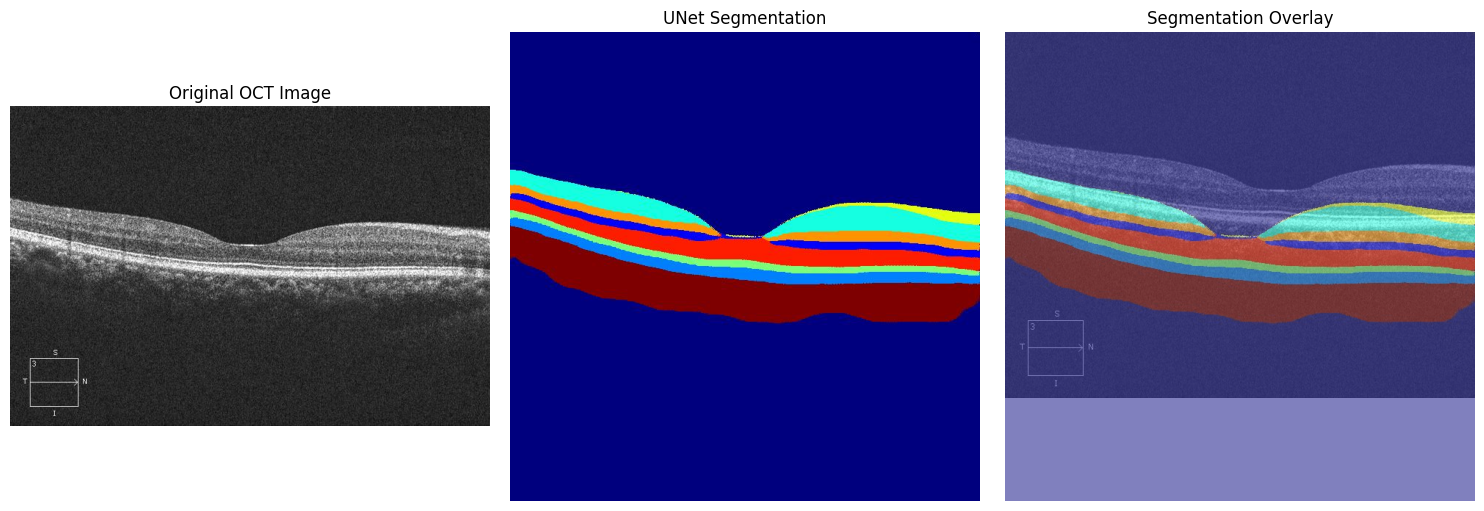

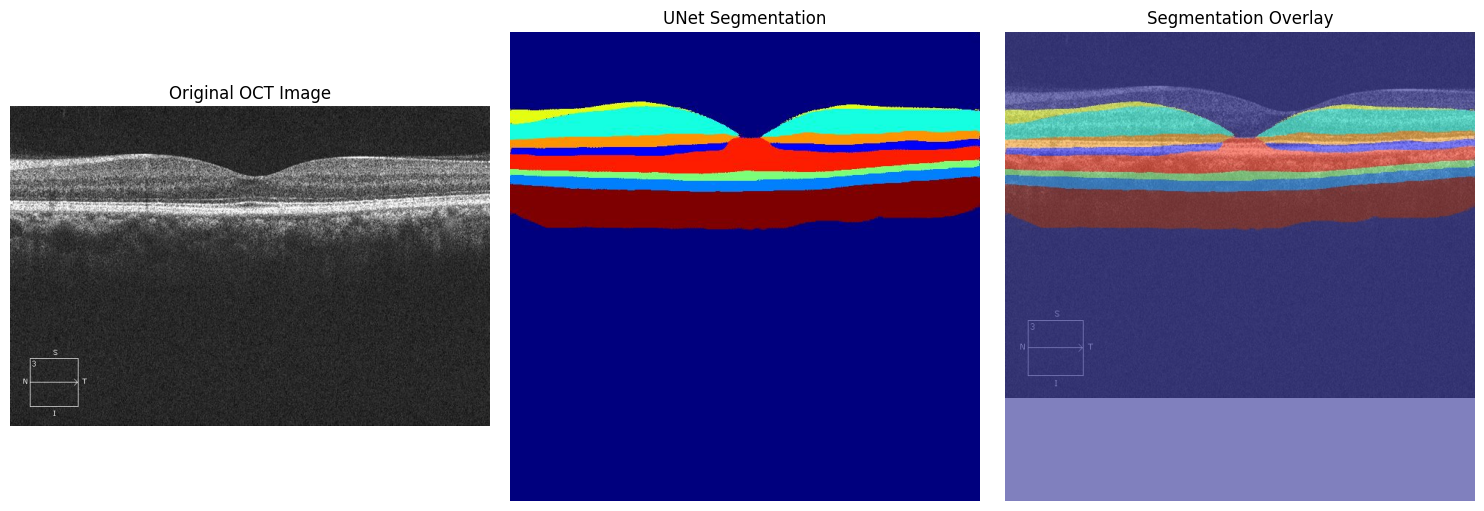

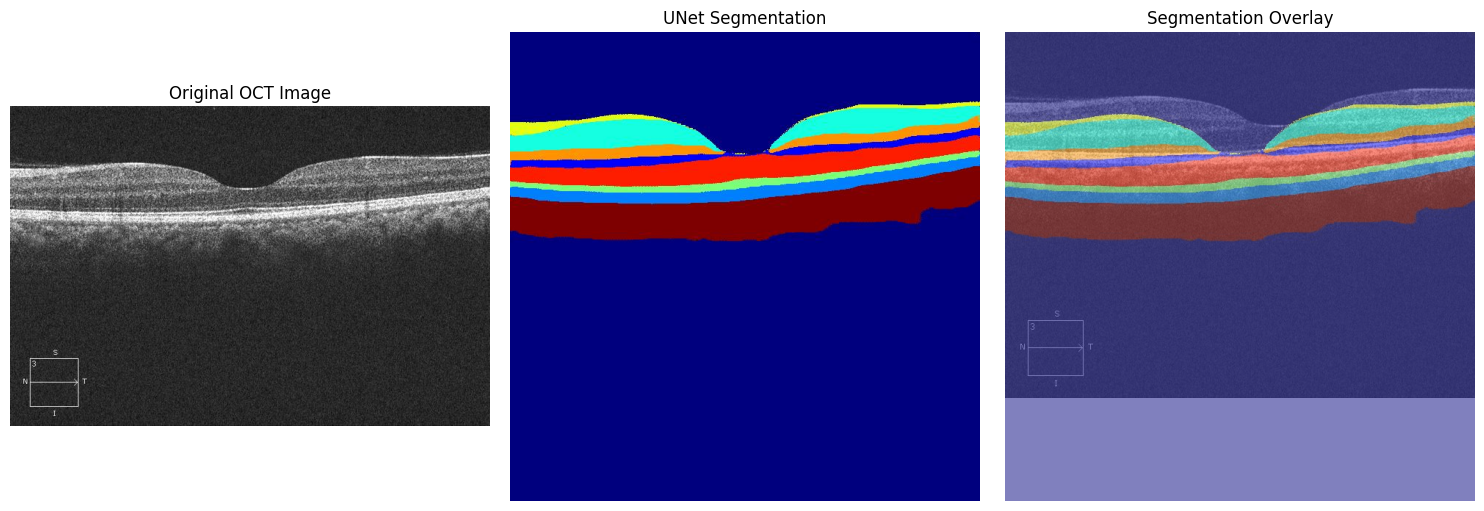

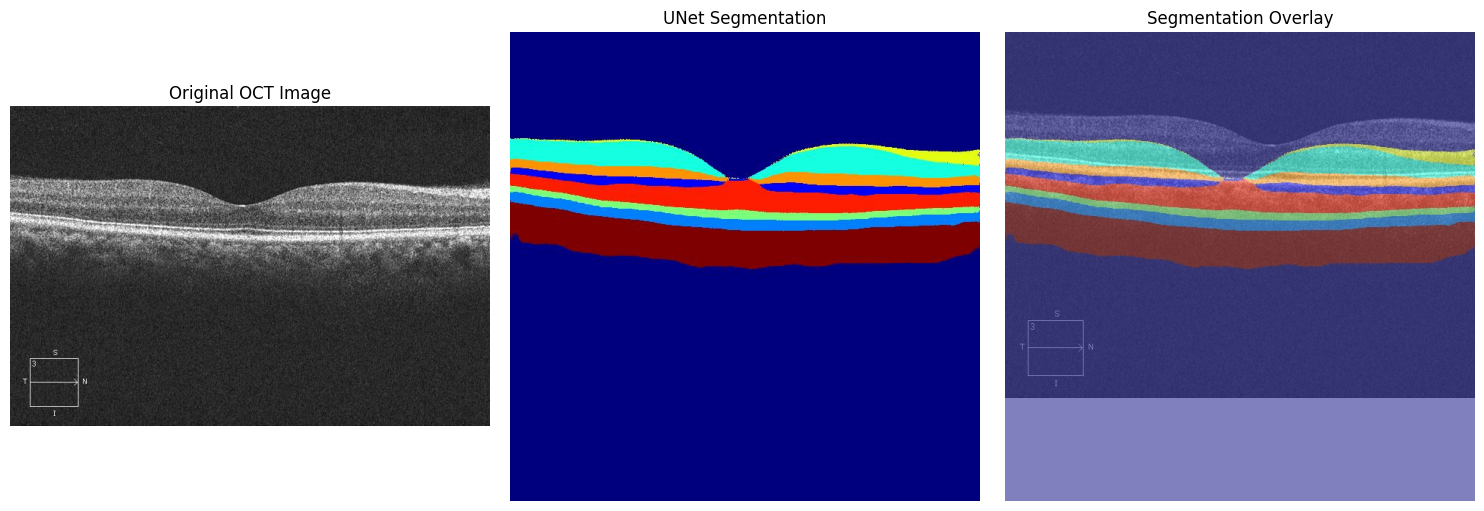

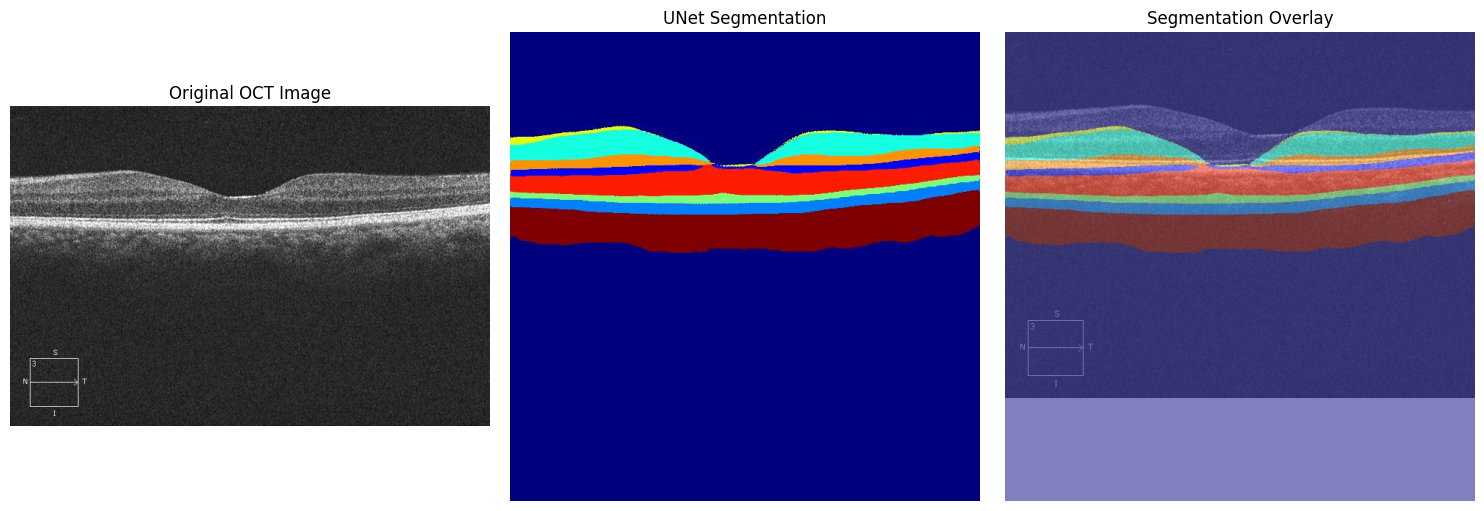

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

# Path to your segmented images
segmented_dir = "/content/drive/My Drive/RetinalDataset/segmented"
original_dir = "/content/drive/My Drive/RetinalDataset/images"

# Show 5 random samples
for i, img_file in enumerate(os.listdir(segmented_dir)[:5]):
    # Load original image and its segmentation
    orig = Image.open(os.path.join(original_dir, img_file))
    segm = Image.open(os.path.join(segmented_dir, img_file))

    # Create visualization
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(orig, cmap='gray')
    plt.title("Original OCT Image")
    plt.axis('off')

    # Segmentation output
    plt.subplot(1, 3, 2)
    plt.imshow(segm, cmap='tab10')
    plt.title("UNet Segmentation")
    plt.axis('off')

    # Overlay (for better context)
    plt.subplot(1, 3, 3)
    plt.imshow(orig, cmap='gray', alpha=0.7)
    plt.imshow(segm, cmap='tab10', alpha=0.5)
    plt.title("Segmentation Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your thickness features CSV
features_path = "/content/drive/My Drive/RetinalDataset/etdrs_features/etdrs_features.csv"
features_df = pd.read_csv(features_path)

# Visualize RNFL thickness distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(features_df["RNFL_mean_total"], bins=15, alpha=0.7)
plt.title("RNFL Mean Thickness Distribution")
plt.xlabel("Thickness (μm)")
plt.ylabel("Count")

# Visualize GCL thickness distribution
plt.subplot(1, 2, 2)
plt.hist(features_df["GCL_mean_total"], bins=15, alpha=0.7, color='g')
plt.title("GCL Mean Thickness Distribution")
plt.xlabel("Thickness (μm)")
plt.tight_layout()
plt.savefig("/content/drive/My Drive/RetinalDataset/etdrs_features/thickness_distribution.png")
plt.close()

In [ ]:
import pandas as pd
import numpy as np
import os
from google.colab import drive

# Mount Google Drive if needed
# drive.mount('/content/drive')

# === Synthetic OCT Layer Thickness Generator for Test Set ===
def generate_synthetic_test_data(n_samples=200, random_state=123):  # Different seed than training set
    np.random.seed(random_state)
    data = []

    # Medical literature-based parameters (same as training set for consistency)
    normal_rnfl_mean, normal_rnfl_std = 95, 5
    normal_gcl_mean, normal_gcl_std = 33, 4
    ad_rnfl_mean, ad_rnfl_std = 72, 8
    ad_gcl_mean, ad_gcl_std = 25, 5

    # Covariance between RNFL and GCL thickness (correlation ~0.8)
    corr_matrix = np.array([[1.0, 0.8],
                            [0.8, 1.0]])

    def generate_correlated_thickness(mean_rnfl, std_rnfl, mean_gcl, std_gcl, n_sectors=9):
        # Cholesky decomposition for correlation
        L = np.linalg.cholesky(corr_matrix)
        uncorrelated = np.random.randn(2, n_sectors)
        correlated = L @ uncorrelated
        rnfl = correlated[0] * std_rnfl + mean_rnfl
        gcl = correlated[1] * std_gcl + mean_gcl
        return rnfl, gcl

    # ---- Generate Normal Subjects (label = 0) ----
    for _ in range(n_samples // 2):
        rnfl, gcl = generate_correlated_thickness(normal_rnfl_mean, normal_rnfl_std,
                                                  normal_gcl_mean, normal_gcl_std)

        # Anatomical asymmetry: temporal sectors thinner (same pattern but different values)
        rnfl[1] -= np.random.uniform(1.5, 2.5)  # Slightly varied from training set
        rnfl[3] -= np.random.uniform(2.5, 3.5)
        gcl[1] -= np.random.uniform(1.0, 1.5)
        gcl[3] -= np.random.uniform(1.5, 2.5)

        # Random small anatomical noise (slightly different distribution)
        rnfl += np.random.normal(0, 1.2, 9)  # Slightly less noise than training
        gcl += np.random.normal(0, 1.2, 9)

        # Apply realistic ranges (same as training)
        rnfl = np.clip(rnfl, 65, 110)
        gcl = np.clip(gcl, 20, 40)

        row = {f"RNFL_mean_s{i+1}": rnfl[i] for i in range(9)}
        row.update({f"GCL_mean_s{i+1}": gcl[i] for i in range(9)})
        row["label"] = 0
        row["AD_risk"] = max(0, min(1, (100 - np.mean(rnfl)) / 35))
        data.append(row)

    # ---- Generate AD Subjects (label = 1) ----
    for _ in range(n_samples // 2):
        rnfl, gcl = generate_correlated_thickness(ad_rnfl_mean, ad_rnfl_std,
                                                  ad_gcl_mean, ad_gcl_std)

        # Stronger thinning in temporal sectors (slightly different magnitudes)
        rnfl[1] -= np.random.uniform(4.5, 5.5)
        rnfl[3] -= np.random.uniform(6.5, 7.5)
        gcl[1] -= np.random.uniform(2.5, 3.5)
        gcl[3] -= np.random.uniform(3.5, 4.5)

        # Random noise (slightly different from training)
        rnfl += np.random.normal(0, 2.0, 9)
        gcl += np.random.normal(0, 2.0, 9)

        # Apply realistic ranges (same as training)
        rnfl = np.clip(rnfl, 50, 90)
        gcl = np.clip(gcl, 15, 35)

        row = {f"RNFL_mean_s{i+1}": rnfl[i] for i in range(9)}
        row.update({f"GCL_mean_s{i+1}": gcl[i] for i in range(9)})
        row["label"] = 1
        row["AD_risk"] = max(0, min(1, (100 - np.mean(rnfl)) / 35))
        data.append(row)

    return pd.DataFrame(data)

# === Generate and Save Test Data ===
test_df = generate_synthetic_test_data(n_samples=200)  # 100 Normal, 100 AD

output_dir = "/content/drive/My Drive/RetinalDataset/synthetic_data"
os.makedirs(output_dir, exist_ok=True)
test_path = os.path.join(output_dir, "synthetic_test_data.csv")
test_df.to_csv(test_path, index=False)

print(f"Synthetic test set saved to: {test_path}")
print(f"Generated {len(test_df)} test samples (balanced)")
print("First 5 rows of test set:")
print(test_df.head())

# === Summary Statistics ===
print("\nTest Set Clinical Statistics:")
print(f"Mean RNFL (Normal): {test_df[test_df['label']==0].filter(like='RNFL').mean().mean():.2f} μm")
print(f"Mean RNFL (AD): {test_df[test_df['label']==1].filter(like='RNFL').mean().mean():.2f} μm")
print(f"Mean GCL (Normal): {test_df[test_df['label']==0].filter(like='GCL').mean().mean():.2f} μm")
print(f"Mean GCL (AD): {test_df[test_df['label']==1].filter(like='GCL').mean().mean():.2f} μm")

# Optional: Verify the test set is different from training set
# (You can run this to confirm it's distinct from training data)
# training_df = pd.read_csv(os.path.join(output_dir, "synthetic_training_data.csv"))
# print("\nDifference check:")
# print(f"First RNFL value in training: {training_df['RNFL_mean_s1'].iloc[0]:.2f}")
# print(f"First RNFL value in test: {test_df['RNFL_mean_s1'].iloc[0]:.2f}")

Synthetic test set saved to: /content/drive/My Drive/RetinalDataset/synthetic_data/synthetic_test_data.csv
Generated 200 test samples (balanced)
First 5 rows of test set:
   RNFL_mean_s1  RNFL_mean_s2  RNFL_mean_s3  RNFL_mean_s4  RNFL_mean_s5  \
0     88.448846     99.263321     94.910236     83.353793     93.195525   
1     90.045917     85.190584     93.422627     93.102822     98.393704   
2     91.582882     82.779933    102.130904     91.819355    103.275211   
3    103.808939     82.834718     95.141828     89.698450     96.271595   
4    101.998440     94.432992     96.776004     90.399623     95.011763   

   RNFL_mean_s6  RNFL_mean_s7  RNFL_mean_s8  RNFL_mean_s9  GCL_mean_s1  \
0    101.542766     82.698521     91.821331    101.022938    24.087498   
1     95.909531    107.016414     96.784850     98.455719    36.033800   
2     99.077511     93.641669     87.336117     91.849066    25.483399   
3     98.486582    103.590980     95.502291     98.774104    40.000000   
4     95

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
except:
    pass

# Path to your synthetic data and model
output_dir = "/content/drive/My Drive/RetinalDataset/synthetic_data"
train_path = os.path.join(output_dir, "synthetic_training_data.csv")
test_path = os.path.join(output_dir, "synthetic_test_data.csv")
model_path = os.path.join(output_dir, "transnet_oct.h5")

# Load synthetic training data (for model training)
train_df = pd.read_csv(train_path)

# Load synthetic test data (for model evaluation)
test_df = pd.read_csv(test_path)

# Prepare features and labels for training
feature_columns = [
    col for col in train_df.columns
    if (col.startswith("RNFL_mean_s") or col.startswith("GCL_mean_s"))
    and "_s" in col
]

# Training data
X_train = train_df[feature_columns].values
y_train = train_df["label"].values

# Test data
X_test = test_df[feature_columns].values
y_test = test_df["label"].values
y_test_scores = test_df["AD_risk"].values

# Standardize features using the training data's statistics
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Load the model
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a custom MultiHeadAttention layer that properly handles arguments
class FixedMultiHeadAttention(layers.MultiHeadAttention):
    def __init__(self, *args, **kwargs):
        # Filter out unexpected keyword arguments
        valid_kwargs = {}
        for k in ['num_heads', 'key_dim', 'value_dim', 'dropout',
                 'use_bias', 'output_shape', 'output_proj',
                 'kernel_initializer', 'bias_initializer',
                 'kernel_regularizer', 'bias_regularizer',
                 'activity_regularizer', 'kernel_constraint',
                 'bias_constraint', 'attention_axes']:
            if k in kwargs:
                valid_kwargs[k] = kwargs[k]

        # Only pass valid arguments
        super().__init__(**valid_kwargs)

# Load model with custom objects
try:
    # First, try to load from the native Keras format (better for custom models)
    model_path_keras = os.path.join(output_dir, "transnet_oct.keras")
    if os.path.exists(model_path_keras):
        model = tf.keras.models.load_model(model_path_keras)
        print("✅ Loaded model from .keras format")
    else:
        # Fall back to .h5 format with custom objects
        custom_objects = {
            'MultiHeadAttention': FixedMultiHeadAttention,
            'LayerNormalization': layers.LayerNormalization,
            'GlobalAveragePooling1D': layers.GlobalAveragePooling1D
        }
        model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
        print("✅ Loaded model from .h5 format with custom objects")
except Exception as e:
    print(f"❌ Error loading model: {str(e)}")
    print("Try retraining the model using the native Keras format:")
    print("model.save('transnet_oct.keras', save_format='keras')")

    # Provide a fallback: create a new model with the same architecture
    print("\nAs a fallback, creating a new model with the same architecture...")

    def build_transnet(input_shape=(18,), num_heads=2, ff_dim=32, n_layers=2):
        inputs = layers.Input(shape=input_shape)
        x = layers.Reshape((-1, 2))(inputs)

        # Add positional encoding
        positions = tf.range(0, 9, dtype=tf.float32)
        positions = layers.Embedding(9, 2)(positions)
        x = x + positions

        # Transformer blocks
        for _ in range(n_layers):
            # Multi-head attention
            attn = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=2
            )(x, x)
            attn = layers.Dropout(0.1)(attn)
            x = layers.Add()([x, attn])
            x = layers.LayerNormalization(epsilon=1e-6)(x)

            # Feed-forward network
            ff = layers.Dense(ff_dim, activation='relu')(x)
            ff = layers.Dense(2)(ff)
            ff = layers.Dropout(0.1)(ff)
            x = layers.Add()([x, ff])
            x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Global pooling and classification
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(16, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)

        model = models.Model(inputs=inputs, outputs=outputs)
        return model

    # Create a new model with the same architecture
    model = build_transnet(input_shape=(18,))

    # Load weights from the .h5 file (this should work even if the architecture is loaded separately)
    model.load_weights(model_path)
    print("✅ Created new model and loaded weights successfully")

# Predict on test set
y_pred_scores = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_scores > 0.5).astype(int)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = auc(roc_curve(y_test, y_pred_scores)[0], roc_curve(y_test, y_pred_scores)[1])

# Print metrics
print("\nPerformance Metrics on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc_score:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Alzheimer']))

# Save metrics to file
metrics_file = os.path.join(output_dir, "test_set_metrics.txt")
with open(metrics_file, "w") as f:
    f.write("Performance Metrics on Test Set\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}\n")
    f.write(f"AUC: {auc_score:.4f}\n\n")
    f.write("Detailed Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['Normal', 'Alzheimer']))

# Create directory for visualizations if it doesn't exist
viz_dir = os.path.join(output_dir, "visualizations")
os.makedirs(viz_dir, exist_ok=True)

# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Alzheimer'],
            yticklabels=['Normal', 'Alzheimer'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(viz_dir, "confusion_matrix_test.png"), dpi=300, bbox_inches='tight')
plt.close()

# 2. ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_scores)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.savefig(os.path.join(viz_dir, "roc_curve_test.png"), dpi=300, bbox_inches='tight')
plt.close()

# 3. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_scores)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test Set)')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, "precision_recall_test.png"), dpi=300, bbox_inches='tight')
plt.close()

# 4. AD Risk Score Distribution
plt.figure(figsize=(10, 6))
plt.hist(y_pred_scores[y_test == 0], bins=20, alpha=0.7, label='Normal', color='blue')
plt.hist(y_pred_scores[y_test == 1], bins=20, alpha=0.7, label='Alzheimer', color='red')
plt.axvline(x=0.5, color='k', linestyle='--', label='Decision Threshold')
plt.title("AD Risk Score Distribution (Test Set)")
plt.xlabel("AD Risk Score")
plt.ylabel("Count")
plt.legend()
plt.savefig(os.path.join(viz_dir, "risk_distribution_test.png"), dpi=300, bbox_inches='tight')
plt.close()

# 5. Actual vs Predicted Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_scores, alpha=0.6)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('True Label (0=Normal, 1=Alzheimer)')
plt.ylabel('Predicted AD Risk Score')
plt.title('True Labels vs Predicted Risk Scores (Test Set)')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, "scatter_plot_test.png"), dpi=300, bbox_inches='tight')
plt.close()

# 6. Threshold Analysis
thresholds = np.linspace(0, 1, 100)
accuracies = []
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_temp = (y_pred_scores > threshold).astype(int)
    accuracies.append(accuracy_score(y_test, y_temp))
    precisions.append(precision_score(y_test, y_temp, zero_division=0))
    recalls.append(recall_score(y_test, y_temp, zero_division=0))
    f1_scores.append(f1_score(y_test, y_temp, zero_division=0))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, 'b-', label='Accuracy')
plt.plot(thresholds, precisions, 'g-', label='Precision')
plt.plot(thresholds, recalls, 'r-', label='Recall')
plt.plot(thresholds, f1_scores, 'm-', label='F1 Score')
plt.axvline(x=0.5, color='k', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Performance Analysis (Test Set)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(viz_dir, "threshold_analysis_test.png"), dpi=300, bbox_inches='tight')
plt.close()

print("All visualizations saved to:", viz_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
❌ Error loading model: too many positional arguments
Try retraining the model using the native Keras format:
model.save('transnet_oct.keras', save_format='keras')

As a fallback, creating a new model with the same architecture...
✅ Created new model and loaded weights successfully
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

Performance Metrics on Test Set:
Accuracy: 0.7700
Precision: 0.8375
Recall: 0.6700
F1 Score: 0.7444
AUC: 0.8454

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.72      0.87      0.79       100
   Alzheimer       0.84      0.67      0.74       100

    accuracy                           0.77       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.77      0.77       200

All visualizations saved to: /content/drive/My Drive/RetinalDataset/synthetic_